In [1]:
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql.types import *

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions  import *
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
spark = SparkSession.builder \
        .master("local[3]") \
        .appName(['Diabetes-EDA']) \
        .getOrCreate()
        

In [4]:
df = spark.read \
    .format('csv') \
    .option('header','true')\
    .option('inferSchema','true')\
    .load('.\data\diabetes.csv')

In [9]:
# Looking at the 1st 5 rows to understand how data looks like
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [7]:
# Looking at the schema of the dataframe
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [13]:
# # Will looks at the stats using describe & converting it to pandas for better readbiliy
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [14]:
# Much better to read
df.describe().toPandas().T
# no. of pregnancies - 17 is an outlier. Need to investigate it further

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [15]:
# Looking at teh outcome total for count
df.groupBy('Outcome').count().show()
# Looks like we have an unbalanced dataset

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



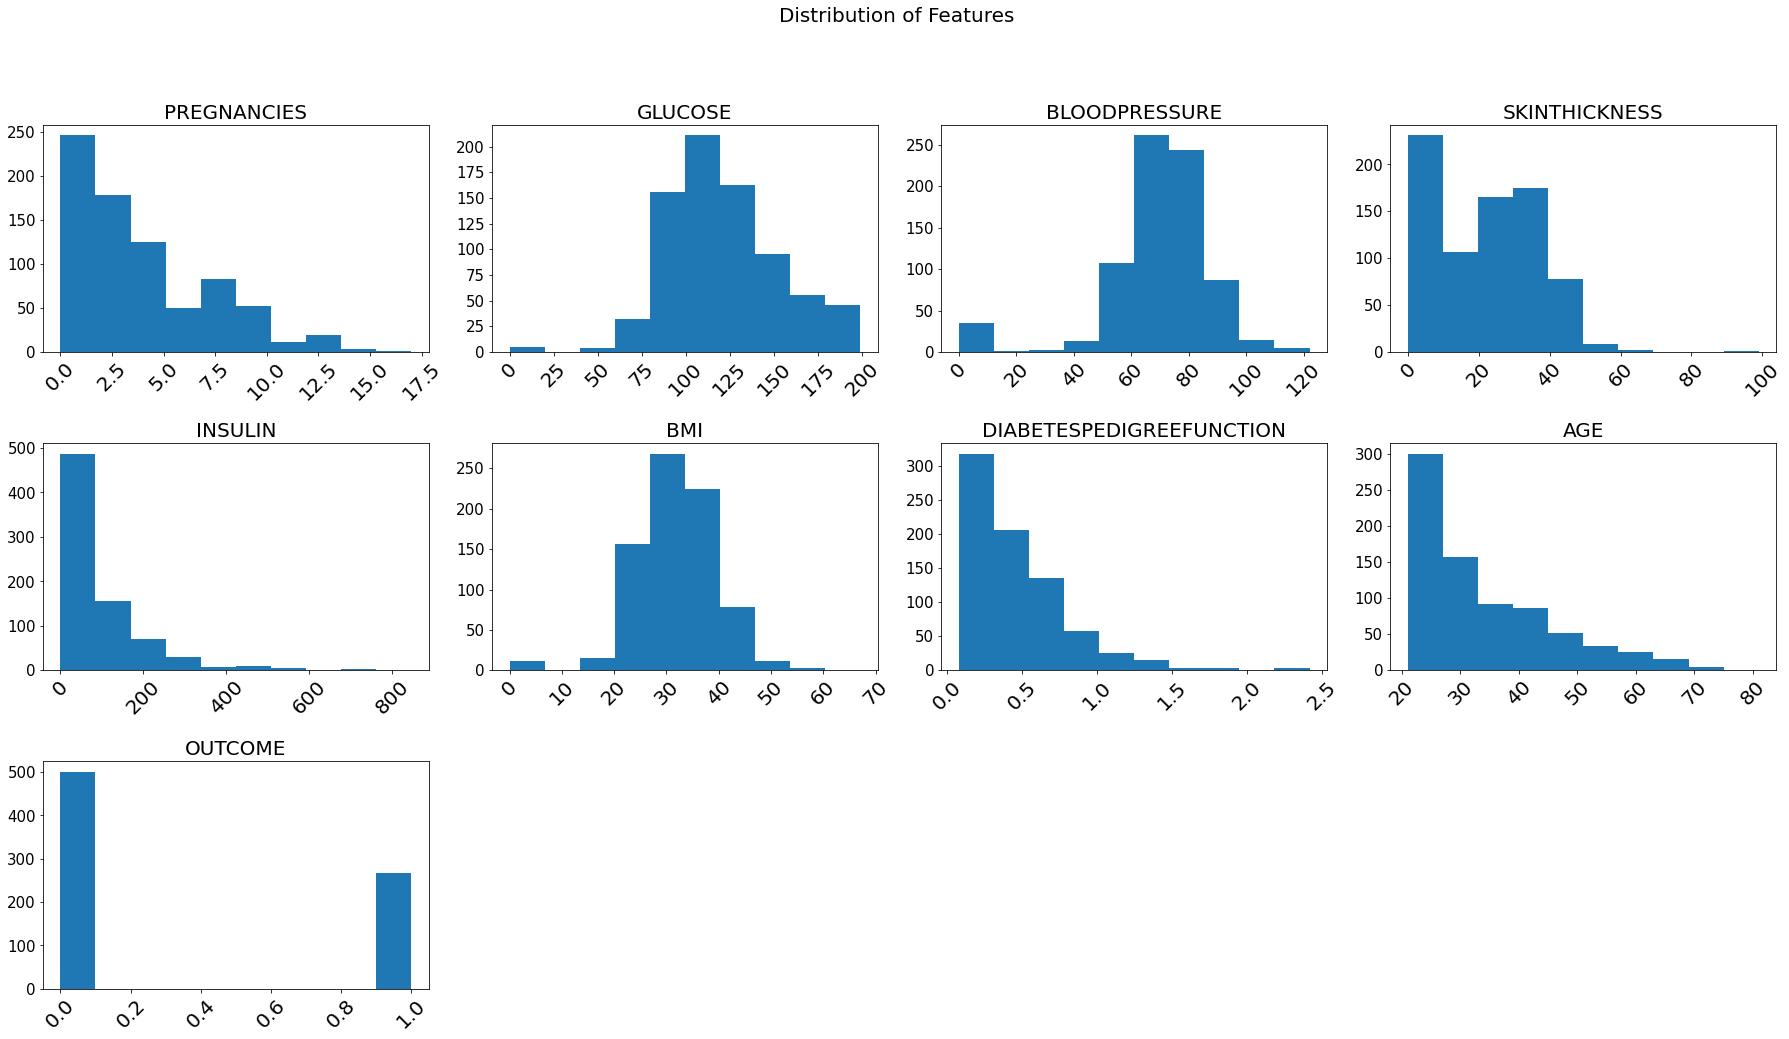

In [34]:
fig = plt.figure(figsize=(25,15))
st = fig.suptitle('Distribution of Features', fontsize = 20, verticalalignment = 'center' )
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize = 20)
    plt.yticks(fontsize = 15)
    plt.title(col.upper(), fontsize = 20 )
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace=0.4)
plt.show()

In [42]:
# Looking at the missing values if any
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [43]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns])

DataFrame[Pregnancies: bigint, Glucose: bigint, BloodPressure: bigint, SkinThickness: bigint, Insulin: bigint, BMI: bigint, DiabetesPedigreeFunction: bigint, Age: bigint, Outcome: bigint]

In [45]:
# Creating a user defined function to conver outcome -1,0 into yes & no

In [49]:
y_udf = udf(lambda y:'no' if y ==0 else 'yes', StringType() )

In [50]:
df = df.withColumn('HasDiabetes', y_udf('Outcome')).drop('Outcome')

In [51]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|         no|
|          3|     78|           50|           32|     88|31.0|  

In [56]:
def udf_multi(age):
    if (age < 25):
        return 'Under 25'
    elif (age >= 25 and age < 35):
        return 'Between 25 and 35'
    elif (age >=35 and age <50):
        return 'Between 36 & 50'
    elif (age >= 50):
        return 'Over 50'
    else: 
        return 'NA'

In [57]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf',age_udf('Age'))

In [58]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|         Under 25|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|Between 25 and 35|
+-----------+-------+---

In [60]:
from pyspark.sql import functions as f
from pyspark.sql.functions import rank, sum, desc
from pyspark.sql import Window

In [61]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [62]:
age_group_tab = df.select(['age_udf', 'Glucose']).\
                groupBy('age_udf').\
                agg(
                f.count('Glucose').alias('UserCount'),
                f.mean('Glucose').alias('Glucose_Avg'),
                f.min('Glucose').alias('Glucose_Min'),
                f.max('Glucose').alias('Glucose_Max'))

In [63]:
age_group_tab.show()

+-----------------+---------+------------------+-----------+-----------+
|          age_udf|UserCount|       Glucose_Avg|Glucose_Min|Glucose_Max|
+-----------------+---------+------------------+-----------+-----------+
|Between 25 and 35|      269|119.61338289962825|         68|        198|
|         Under 25|      219|110.85844748858447|          0|        199|
|  Between 36 & 50|      191| 125.5130890052356|          0|        197|
|          Over 50|       89| 139.5505617977528|         57|        197|
+-----------------+---------+------------------+-----------+-----------+



In [64]:
age_group_tab = df.select(['age_udf', 'Glucose']).\
                groupBy('age_udf').\
                agg(
                f.count('Glucose').alias('UserCount'),
                f.mean('Glucose').alias('Glucose_Avg'),
                f.min('Glucose').alias('Glucose_Min'),
                f.max('Glucose').alias('Glucose_Max')).\
                withColumn('Total',sum(col('UserCount')).over(window)).\
                withColumn('Percent',col('UserCount')*100/col('Total')).\
                drop(col('Total')).sort(desc('Percent'))

In [66]:
age_group_tab.show()

+-----------------+---------+------------------+-----------+-----------+------------------+
|          age_udf|UserCount|       Glucose_Avg|Glucose_Min|Glucose_Max|           Percent|
+-----------------+---------+------------------+-----------+-----------+------------------+
|Between 25 and 35|      269|119.61338289962825|         68|        198|35.026041666666664|
|         Under 25|      219|110.85844748858447|          0|        199|         28.515625|
|  Between 36 & 50|      191| 125.5130890052356|          0|        197|24.869791666666668|
|          Over 50|       89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+---------+------------------+-----------+-----------+------------------+



In [67]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_Avg,Glucose_Min,Glucose_Max,Percent
0,Between 25 and 35,269,119.613383,68,198,35.026042
1,Under 25,219,110.858447,0,199,28.515625
2,Between 36 & 50,191,125.513089,0,197,24.869792
3,Over 50,89,139.550562,57,197,11.588542


<AxesSubplot:xlabel='age_udf', ylabel='Percent'>

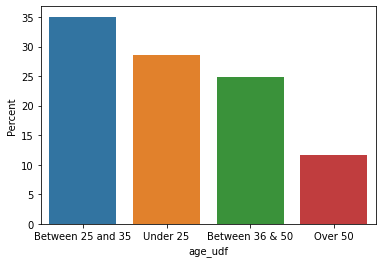

In [69]:
sns.barplot(x = 'age_udf',y = 'Percent',data = age_group_tab.toPandas())

# correlation

In [70]:
# Looking at teh numerica features

In [71]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



In [78]:
df.dtypes

[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'double'),
 ('DiabetesPedigreeFunction', 'double'),
 ('Age', 'int'),
 ('HasDiabetes', 'string'),
 ('age_udf', 'string')]

In [74]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']

In [85]:
numeric_features_df = df.select(numeric_features)
numeric_features_df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+
only showing top 5 rows



In [86]:
 df.select(numeric_features).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [87]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row:row[0:])

In [88]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [96]:
corr_mat = Statistics.corr(features, method = 'pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names



In [103]:
corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


<AxesSubplot:>

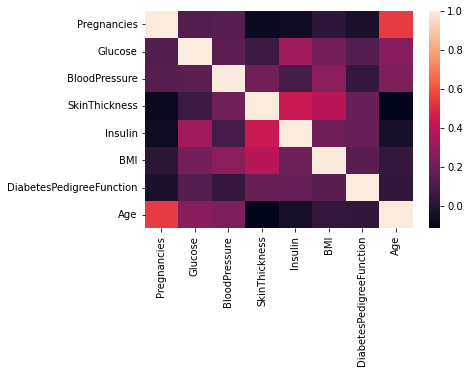

In [104]:
sns.heatmap(corr_df)